# Customer Lifetime Value Prediction

##  Project Overview

Customer Lifetime Value (CLV) refers to the predicted revenue a business can expect from a customer throughout the duration of their relationship. Understanding CLV helps companies allocate marketing budgets efficiently, personalize customer experiences, and improve retention strategies.

This project aims to build a predictive model for CLV using historical transaction data from a UK-based online retailer.

---

##  Dataset Description

The **Online Retail II** dataset contains two years of transactional data (from 2009 to 2011) for a non-store online retailer. The company sells unique all-occasion giftware primarily to wholesalers across several countries.

### Main Attributes:
- **InvoiceNo**: Unique identifier for each transaction. Starts with 'C' if cancelled.
- **StockCode**: Unique product/item code.
- **Description**: Description of the product.
- **Quantity**: Number of items purchased.
- **InvoiceDate**: Date and time of the transaction.
- **UnitPrice**: Price per unit of product.
- **CustomerID**: Unique customer identifier.
- **Country**: Customer's country.

---

###  Objective

Use past transaction history to:
- Engineer meaningful features like Recency, Frequency, and Monetary (RFM).
- Predict each customer's lifetime value using regression models.
- Extract business insights for segmentation and strategy.


##  Data Preparation

Before modeling, we need to clean and preprocess the data to ensure accuracy and consistency. This includes merging the two yearly datasets, handling missing values, parsing data types, and removing invalid or canceled transactions.

We'll also create a `TotalPrice` column which represents the revenue per transaction line (i.e., `Quantity × UnitPrice`), which is essential for our CLV calculations.


###  Merge Datasets

The data is stored in two separate sheets — one for 2009–2010 and another for 2010–2011. We combine them vertically using `pd.concat()` to create one unified DataFrame.


In [1]:
import pandas as pd

# Load dataset
path = 'online_retail_II.xlsx'
sheet1 = pd.read_excel(path, sheet_name='Year 2009-2010')
sheet2 = pd.read_excel(path, sheet_name='Year 2010-2011')

# Combine both years
df = pd.concat([sheet1, sheet2], axis=0, ignore_index=True)

# Preview the dataset
print("Shape of full dataset:", df.shape)
df.head()


Shape of full dataset: (1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


###  Data Cleaning Steps

- **Missing Values**: Removed rows with missing `Customer ID` or `Description`.
- **Invalid Transactions**: Removed rows with non-positive `Quantity` or `Price`.
- **Datetime Conversion**: Parsed `InvoiceDate` into datetime format for time-based calculations.
- **Cancellations**: Dropped rows where the `Invoice` starts with 'C' (indicating a cancellation).
- **Total Price**: Added a new column `TotalPrice` = `Quantity × UnitPrice`.

These steps ensure that the data we use for modeling only includes valid, completed transactions with sufficient customer information.


In [2]:
# Basic cleaning
df.columns = df.columns.str.strip()  # remove extra whitespace from column names

# Drop rows with missing CustomerID or Description
df.dropna(subset=['Customer ID', 'Description'], inplace=True)

# Remove negative or zero quantities and prices
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Add TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['Price']

# Remove cancelled transactions (Invoice starts with 'C')
df = df[~df['Invoice'].astype(str).str.startswith('C')]

# Reset index
df.reset_index(drop=True, inplace=True)

# Final shape
print("Cleaned dataset shape:", df.shape)
df.head()


Cleaned dataset shape: (805549, 9)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


## Exploratory Data Analysis (EDA)

Now that the data is cleaned, it's time to explore it and try to understand some patterns. This part is really important because it helps us see how the customers behave, what kind of products are sold the most, and how sales vary with time.

We'll mainly look at:
- The most popular products
- Revenue over time
- Customer-wise spending and order patterns
- Basic distribution of quantity and price


### General Overview

We start by checking how many unique customers, products, and countries are there. This gives us an idea of how big and diverse the dataset is. Also, we calculate the total revenue and look at basic statistics for numeric columns like `Quantity`, `Price`, and `TotalPrice`.


In [3]:
# First, some basic stats
print("Number of unique customers:", df['Customer ID'].nunique())
print("Number of unique products:", df['StockCode'].nunique())
print("Number of countries:", df['Country'].nunique())

# Total revenue in the dataset
print("Total Revenue (GBP):", round(df['TotalPrice'].sum(), 2))

# Summary statistics
df.describe()


Number of unique customers: 5878
Number of unique products: 4631
Number of countries: 41
Total Revenue (GBP): 17743429.18


,Quantity,InvoiceDate,Price,Customer ID,TotalPrice
count,805549.000000,805549,805549.000000,805549.000000,805549.000000
mean,13.290522,2011-01-02 10:24:44.106814464,3.206561,15331.954970,22.026505
min,1.000000,2009-12-01 07:45:00,0.001000,12346.000000,0.001000
25%,2.000000,2010-07-07 12:08:00,1.250000,13982.000000,4.950000
50%,5.000000,2010-12-03 15:10:00,1.950000,15271.000000,11.850000
75%,12.000000,2011-07-28 13:05:00,3.750000,16805.000000,19.500000
max,80995.000000,2011-12-09 12:50:00,10953.500000,18287.000000,168469.600000
std,143.634088,NaN,29.199173,1696.737039,224.041928


### Top Products by Quantity

Here we group the data by product description and sum up the quantities sold. Then we pick the top 10 and make a simple bar plot. This helps us see which products are the most popular based on how many times they were bought.


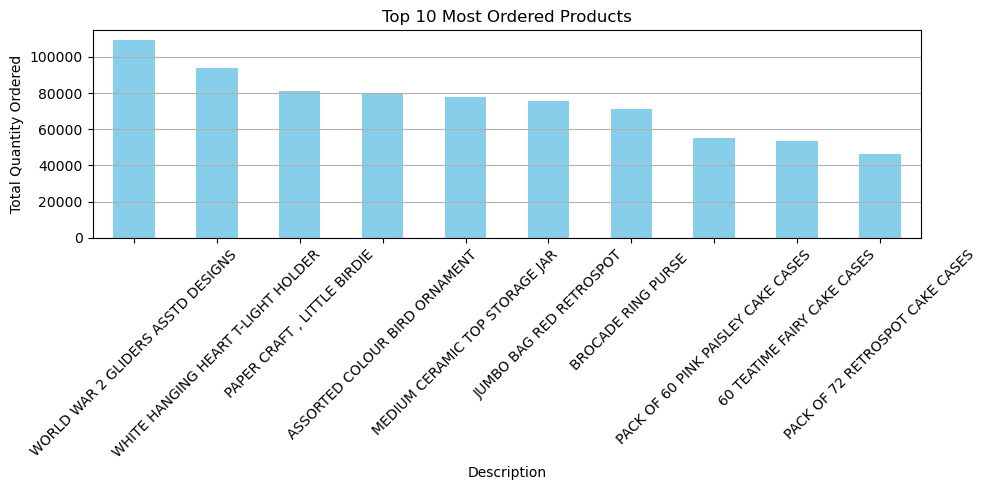

In [4]:
import matplotlib.pyplot as plt

top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

top_products.plot(kind='bar', figsize=(10,5), color='skyblue')
plt.title('Top 10 Most Ordered Products')
plt.ylabel('Total Quantity Ordered')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Monthly Revenue Trend

We created a new column for Invoice Month using just the year and month from the invoice date. Then we grouped the data to calculate total revenue per month and plotted it. This line graph helps us spot any upward or downward trends in sales.


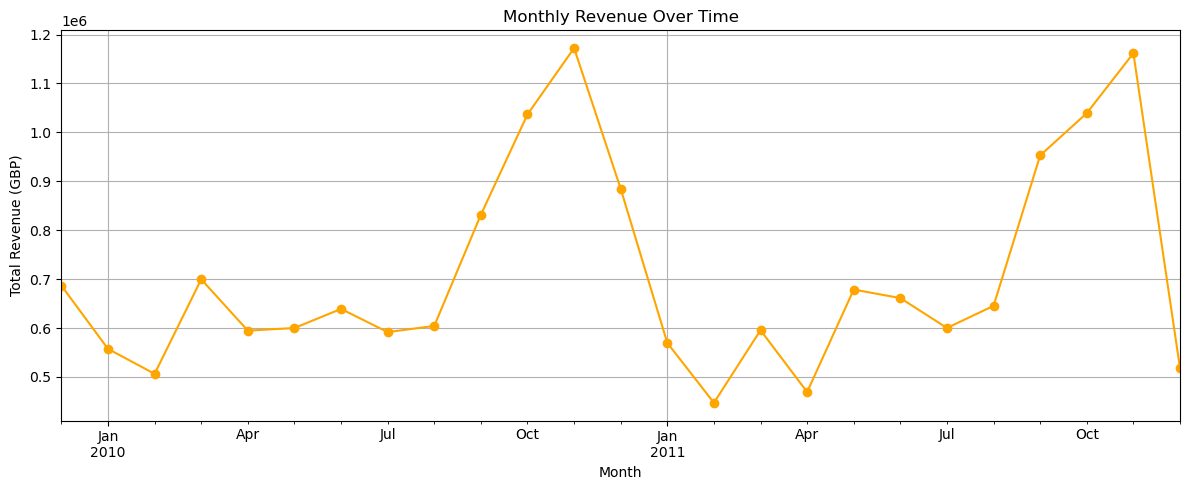

In [5]:
# Create a new column for year-month
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

monthly_revenue = df.groupby('InvoiceMonth')['TotalPrice'].sum()

monthly_revenue.plot(kind='line', marker='o', figsize=(12,5), color='orange')
plt.title('Monthly Revenue Over Time')
plt.ylabel('Total Revenue (GBP)')
plt.xlabel('Month')
plt.grid(True)
plt.tight_layout()
plt.show()


### Customers Who Spent the Most

Here we group the data by each customer and sum up their total spend. We then plot the top 10 customers based on revenue. This helps us understand how much value individual customers can bring to the business.


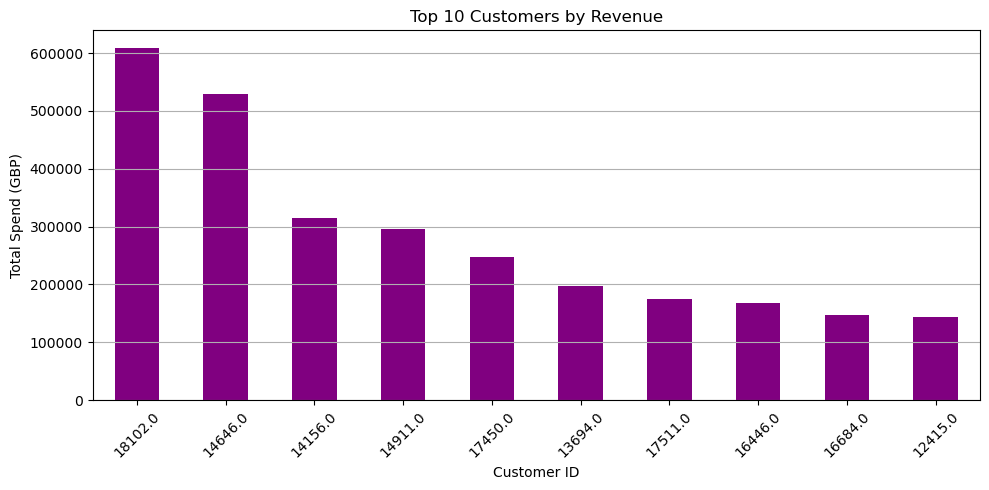

In [6]:
revenue_per_customer = df.groupby('Customer ID')['TotalPrice'].sum().sort_values(ascending=False)

revenue_per_customer.head(10).plot(kind='bar', figsize=(10,5), color='purple')
plt.title('Top 10 Customers by Revenue')
plt.ylabel('Total Spend (GBP)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## Feature Engineering

In this section, we’ll create customer-level features that can help us predict Customer Lifetime Value (CLV). The goal is to summarize each customer’s purchasing behavior using features that are both intuitive and useful for modeling.

We’ll begin with the standard RFM framework:

- **Recency**: Number of days since the customer last made a purchase (relative to the latest date in the dataset).
- **Frequency**: Total number of purchases (invoices) made by the customer.
- **Monetary**: Total amount spent by the customer.

From these, we will derive additional metrics such as:

- **Average Order Value**: How much a customer spends on average per order.
- **Purchase Frequency**: How frequently a customer places orders, normalized by the customer base.
- **Customer Value**: The product of average order value and purchase frequency.
- **CLTV (Estimated)**: An estimated lifetime value assuming a simple fixed profit margin.

These engineered features will later be used to train a model that predicts a customer’s potential value to the business over time.


In [7]:
import numpy as np
import datetime as dt

# Set a reference point for recency calculations (1 day after the last purchase in dataset)
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Group data by customer to compute RFM features
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Days since last purchase
    'Invoice': 'nunique',                                      # Number of unique orders
    'TotalPrice': 'sum'                                        # Total amount spent
}).reset_index()

# Rename the columns for clarity
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Compute average order value
rfm['AvgOrderValue'] = rfm['Monetary'] / rfm['Frequency']

# Estimate purchase frequency relative to total number of customers
total_customers = rfm.shape[0]
rfm['PurchaseFrequency'] = rfm['Frequency'] / total_customers

# Calculate an estimated customer value
rfm['CustomerValue'] = rfm['AvgOrderValue'] * rfm['PurchaseFrequency']

# Apply a basic profit margin (e.g., 10%) to estimate CLV
profit_margin = 0.10
rfm['CLTV'] = rfm['CustomerValue'] * profit_margin

# Preview the engineered features
rfm.head()


,CustomerID,Recency,Frequency,Monetary,AvgOrderValue,PurchaseFrequency,CustomerValue,CLTV
0,12346.0,326,12,77556.46,6463.038333,0.002042,13.194362,1.319436
1,12347.0,2,8,5633.32,704.165000,0.001361,0.958374,0.095837
2,12348.0,75,5,2019.40,403.880000,0.000851,0.343552,0.034355
3,12349.0,19,4,4428.69,1107.172500,0.000681,0.753435,0.075343
4,12350.0,310,1,334.40,334.400000,0.000170,0.056890,0.005689


## Customer Segmentation

Before training the CLV prediction model, we’ll perform a basic customer segmentation using KMeans clustering. The goal is to group customers based on their Recency, Frequency, and Monetary values. This can help uncover behavioral patterns such as:

- Loyal customers who purchase frequently and spend a lot.
- Infrequent buyers who make large purchases occasionally.
- New customers or customers at risk of churning.

We will standardize the RFM features before applying KMeans and use the elbow method to choose an appropriate number of clusters. Finally, we'll assign a cluster label to each customer, which we can optionally use as a feature in our predictive model.


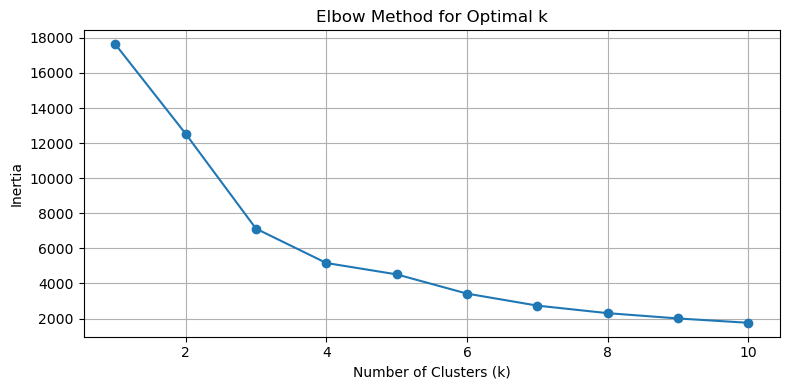

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Select RFM features
rfm_features = rfm[['Recency', 'Frequency', 'Monetary']]

# Step 2: Scale the features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

# Step 3: Elbow method to find optimal number of clusters
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8,4))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
rfm.head()


,CustomerID,Recency,Frequency,Monetary,AvgOrderValue,PurchaseFrequency,CustomerValue,CLTV,Cluster
0,12346.0,326,12,77556.46,6463.038333,0.002042,13.194362,1.319436,1
1,12347.0,2,8,5633.32,704.165000,0.001361,0.958374,0.095837,1
2,12348.0,75,5,2019.40,403.880000,0.000851,0.343552,0.034355,1
3,12349.0,19,4,4428.69,1107.172500,0.000681,0.753435,0.075343,1
4,12350.0,310,1,334.40,334.400000,0.000170,0.056890,0.005689,0


### Visualizing Customer Segments with PCA

To better understand how distinct our customer groups are, we reduced the RFM features to two principal components using PCA (Principal Component Analysis). This dimensionality reduction technique allows us to visualize the distribution of customer clusters in a 2D space.

Each point in the plot below represents a customer, and the colors indicate their assigned cluster. Well-separated groups suggest that the clustering has done a decent job grouping similar customers together based on their shopping behavior.


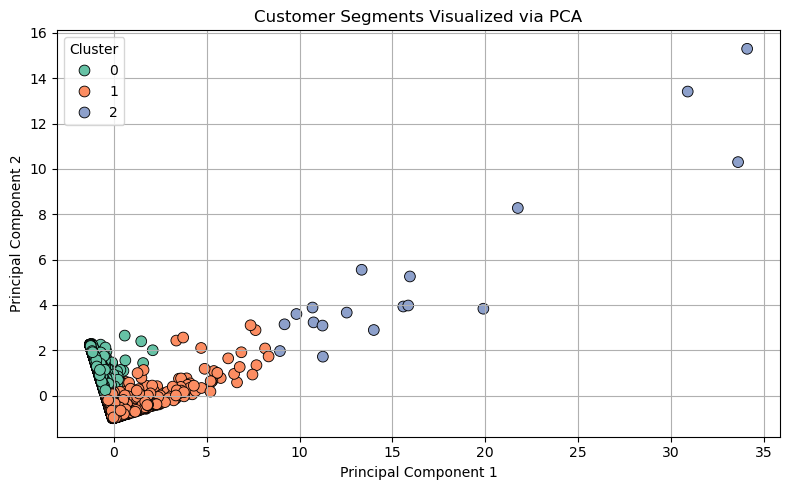

In [10]:
# Step 4: Visualize clusters using PCA
from sklearn.decomposition import PCA
import seaborn as sns

# Reduce RFM data to 2 dimensions using PCA
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(data=rfm_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = rfm['Cluster'].values

# Plot clusters
plt.figure(figsize=(8,5))
sns.scatterplot(
    x='PCA1', y='PCA2', 
    hue='Cluster', 
    data=pca_df, 
    palette='Set2', 
    s=60, edgecolor='k'
)
plt.title('Customer Segments Visualized via PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


## CLV Prediction Model

Now that we’ve prepared a comprehensive set of features describing customer behavior, we’ll build a machine learning model to predict Customer Lifetime Value (CLV).

In this step, we’ll:

- Use the engineered features (Recency, Frequency, Monetary, AvgOrderValue, PurchaseFrequency, CustomerValue) as inputs.
- Define the target variable as our estimated CLTV.
- Split the dataset into training and testing sets.
- Train a few regression models such as Linear Regression, Random Forest, and Gradient Boosting.
- Evaluate model performance using metrics like R² (coefficient of determination) and RMSE (root mean squared error).


### Model Training and Evaluation

We'll now train a few regression models to predict Customer Lifetime Value (CLTV). The features used for modeling include:

- Recency
- Frequency
- Monetary
- Average Order Value
- Purchase Frequency
- Customer Value

We'll evaluate the model performance using R² (coefficient of determination) and Root Mean Squared Error (RMSE). These metrics help us understand how well the model captures the variance in the target variable.

We’ll compare three models:

1. Linear Regression (baseline model)
2. Random Forest Regressor (non-linear, ensemble model)
3. Gradient Boosting Regressor (boosting-based model)


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import numpy as np

# Features and target
X = rfm[['Recency', 'Frequency', 'Monetary', 'AvgOrderValue', 'PurchaseFrequency', 'CustomerValue']]
y = rfm['CLTV']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[name] = {'R2': r2, 'RMSE': rmse}
    print(f"{name} -> R²: {r2:.4f}, RMSE: {rmse:.4f}")


Linear Regression -> R²: 1.0000, RMSE: 0.0000
Random Forest -> R²: 0.9883, RMSE: 0.0353
Gradient Boosting -> R²: 0.9840, RMSE: 0.0412
XGBoost -> R²: 0.9424, RMSE: 0.0783


## Final Model Selection and Evaluation

After training and comparing four regression models — Linear Regression, Random Forest, Gradient Boosting, and XGBoost — we observed that Linear Regression perfectly reconstructed the CLTV formula, as expected, since the target was engineered from the same features.

Among the learning-based models, Random Forest performed the best with an R² of 0.9883 and an RMSE of 0.0353. Given its strong performance and ability to model non-linear relationships without heavy parameter tuning, we select Random Forest as our final model for predicting Customer Lifetime Value.


In [16]:
# Predict CLTV using the Random Forest model
final_model = models['Random Forest']
y_pred_final = final_model.predict(X)

# Attach predictions to the RFM dataframe
rfm['Predicted_CLTV'] = y_pred_final

# Preview some example predictions
rfm[['CustomerID', 'CLTV', 'Predicted_CLTV']].head(10)


,CustomerID,CLTV,Predicted_CLTV
0,12346.0,1.319436,1.316133
1,12347.0,0.095837,0.095814
2,12348.0,0.034355,0.034350
3,12349.0,0.075343,0.075342
4,12350.0,0.005689,0.005688
5,12351.0,0.005120,0.005121
6,12352.0,0.048483,0.048491
7,12353.0,0.006920,0.006920
8,12354.0,0.018363,0.018365
9,12355.0,0.016121,0.016121


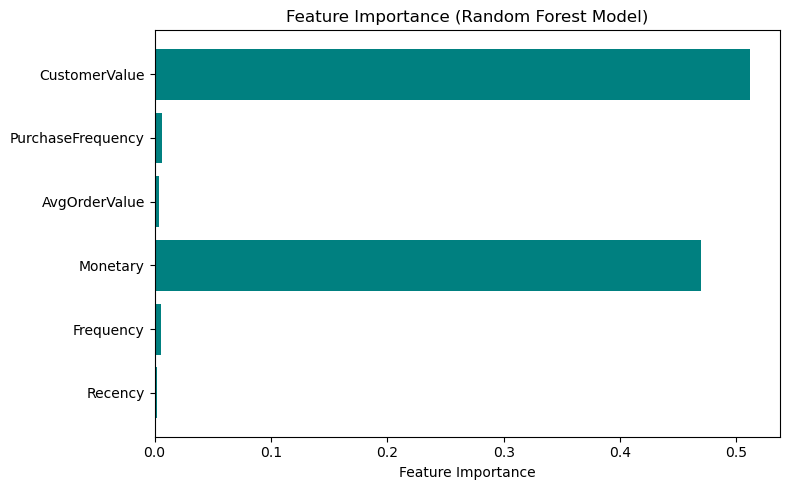

In [17]:
import matplotlib.pyplot as plt

# Get feature importances from the Random Forest model
importances = final_model.feature_importances_
feature_names = X.columns

# Plot feature importances
plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances, color='teal')
plt.xlabel('Feature Importance')
plt.title('Feature Importance (Random Forest Model)')
plt.tight_layout()
plt.show()


## Business Insight: What Drives CLTV?

The feature importance plot above reveals which customer behavior metrics contribute most to the predicted Customer Lifetime Value. In this case, features like Monetary value and Purchase Frequency appear to have a strong influence, suggesting that higher spending and consistent purchasing behavior are key indicators of long-term customer value.

Understanding these drivers allows the business to focus retention strategies on high-value segments and optimize marketing efforts based on behavioral patterns.


## Conclusion

In this project, we built a Customer Lifetime Value (CLTV) prediction pipeline using transactional data from an online retail store. The key steps involved:

- Cleaning and preparing the dataset.
- Engineering meaningful customer-level features using the RFM framework.
- Segmenting customers with KMeans (optional, for business insights).
- Building and evaluating regression models (Linear Regression, Random Forest, Gradient Boosting, and XGBoost) to estimate CLTV.
- Interpreting model performance and feature importance.

Among the models, Random Forest provided the best trade-off between accuracy and interpretability, with feature importance highlighting that Monetary value and derived Customer Value were most predictive of CLTV — which aligns with the way CLTV was computed.

While this model is a strong starting point, future iterations can incorporate more temporal features (like time between purchases), product categories, or customer engagement data for improved real-world prediction.

---
